In [61]:
import pytse_client as tse
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# tickers = tse.download(symbols="all", write_to_csv=True)

Device = ("cuda"
          if torch.cuda.is_available()
          else "cpu"
)
print(f"Using {Device} device")


Using cuda device


In [62]:
sym="آباد"
ticker=tse.Ticker(sym)
length=ticker.history.shape[0]
train_length = int(np.floor(length*0.70))
test_length = length - train_length
days_history=100
days_predict=30

# Now we extract some portion of the first sequences of data for train
X_train=np.zeros([train_length - days_history - days_predict , days_history,5])
Y_train=np.zeros([train_length - days_history - days_predict , days_predict])
for i in range(train_length - days_history - days_predict):
    m = ticker.history.loc[i : i + days_history - 1].to_numpy()
    X_train[i,:,:] = np.array([m[:,9]/m[0,9] , m[:,7]/1e3 , m[:,6]/1e6 , m[:,2]/1e4 , m[:,3]/1e4 ]).T
    m = ticker.history.loc[i + days_history : i + days_history - 1 + days_predict].to_numpy()
    Y_train[i,:] = m[:,9]/m[0,9]

# Now we extract some portion of the last sequences of data for test
X_test=np.zeros([test_length - days_predict , days_history,5])
Y_test=np.zeros([test_length - days_predict , days_predict])
for i in range(test_length - days_predict):
    j = i + train_length - days_history
    m = ticker.history.loc[j : j + days_history - 1].to_numpy()
    X_test[i,:,:] = np.array([m[:,9]/m[0,9] , m[:,7]/1e3 , m[:,6]/1e6 , m[:,2]/1e4 , m[:,3]/1e4 ]).T
    m = ticker.history.loc[j + days_history : j + days_history - 1 + days_predict].to_numpy()
    Y_test[i,:] = m[:,9]/m[0,9]

train_arr = np.arange(train_length - days_history - days_predict - 1)
train_idx = np.random.permutation(train_arr)
X_train = X_train[train_idx]
Y_train = Y_train[train_idx]

test_arr = np.arange(test_length - days_predict - 1)
test_idx = np.random.permutation(test_arr)
X_test = X_test[test_idx]
Y_test = Y_test[test_idx]
X_train = torch.from_numpy(X_train).to(device=Device,dtype=torch.float32)
Y_train = torch.from_numpy(Y_train).to(device=Device,dtype=torch.float32)

X_test = torch.from_numpy(X_test).to(device=Device,dtype=torch.float32)
Y_test = torch.from_numpy(Y_test).to(device=Device,dtype=torch.float32)

In [63]:
class Model(nn.Module):
    def __init__(self,input_size,output_size):
        n=128
        super().__init__()
        self.Lin1 = nn.Linear(input_size,2*n)
        self.Lin2 = nn.Linear(2*n,4*n)
        self.Lin3 = nn.Linear(4*n,2*n)
        self.Lin4 = nn.Linear(2*n,n)
        self.Lin5 = nn.Linear(n,output_size)
        self.activation1 = nn.LeakyReLU(negative_slope=0.01)
        self.activation2 = nn.Tanh()
        self.drop = nn.Dropout(p=0.9)
        self.norm = nn.BatchNorm1d(4*n)
    def forward(self, x):
        x = self.Lin1(x)
        x = self.activation1(x)
        x = self.drop(x) ###
        x = self.Lin2(x)
        #x = self.norm(x) ####
        x = self.activation1(x)
        x = self.drop(x) ###
        x = self.Lin3(x)
        x = self.activation1(x)
        x = self.drop(x) ###

        x = self.Lin4(x)
        x = self.activation1(x) 
        x = self.drop(x) ###
        x = self.Lin5(x)
        x = self.drop(x) ###
        return x

model=Model(days_history*5,days_predict).to(device=Device)
optimizer = torch.optim.RMSprop(model.parameters(),lr=0.001)
LossFn = nn.HuberLoss()
gama=0.99
W_gama=torch.diag(torch.tensor([gama**(1*i) for i in range(days_predict)],device=Device))
#for p in model.parameters():
#    p.data.fill_(0)

In [64]:
batch_size = 300
train_Losses=[]
test_Losses=[]
N_train = int(np.floor(X_train.size(0)/batch_size))
N_test = int(np.floor(X_test.size(0)/batch_size))

for epoch in range(100):
    model.train()
    train_loss=torch.tensor(0,dtype=torch.float32)
    for i in range(N_train):
        x = torch.flatten(X_train[i*batch_size:(i+1)*batch_size,:,:],start_dim=1)
        y = Y_train[i*batch_size:(i+1)*batch_size,:]
        optimizer.zero_grad()
        out = model(x) #+ y[:,0].unsqueeze(1)
        loss_train = LossFn(y@W_gama,out@W_gama)
        loss_train.backward()
        #nn.utils.clip_grad_norm(model.parameters(),1)
        optimizer.step()
        train_loss += loss_train.detach().item()
    train_Losses.append( train_loss/N_train )
   
    model.eval()
    test_loss=torch.tensor(0,dtype=torch.float32)
    test_acc=torch.tensor(0,dtype=torch.float32)
    with torch.no_grad():
        for i in range(N_test):
            x = torch.flatten(X_test[i*batch_size:(i+1)*batch_size,:,:],start_dim=1)
            y = Y_test[i*batch_size:(i+1)*batch_size,:].detach()
            out = model(x) + y[:,0].unsqueeze(1) 
            loss_test = LossFn(y@W_gama,out@W_gama)
            test_loss += loss_test.detach().item()
            temp=y-out
            test_acc += torch.sum(1-torch.abs(y@W_gama-out@W_gama)/y@W_gama).detach().item()
    test_Losses.append( test_loss/N_test )
    accuracy = test_acc / (N_test*batch_size*days_predict) *100
    print(f'{epoch}: train loss is {train_Losses[epoch]} & test loss is {test_Losses[epoch]} & accuracy is %{accuracy}')

0: train loss is 0.6782433986663818 & test loss is 0.021083205938339233 & accuracy is %47.40907287597656
1: train loss is 0.3833128809928894 & test loss is 0.020741067826747894 & accuracy is %46.36512756347656
2: train loss is 0.37374523282051086 & test loss is 0.020647911354899406 & accuracy is %45.569488525390625
3: train loss is 0.3683484196662903 & test loss is 0.020678216591477394 & accuracy is %44.998653411865234
4: train loss is 0.3651700019836426 & test loss is 0.020724965259432793 & accuracy is %44.582550048828125
5: train loss is 0.3611616790294647 & test loss is 0.020781973376870155 & accuracy is %44.23398208618164
6: train loss is 0.3617899715900421 & test loss is 0.020833855494856834 & accuracy is %43.979557037353516
7: train loss is 0.35905832052230835 & test loss is 0.020890863612294197 & accuracy is %43.74436569213867
8: train loss is 0.3579178750514984 & test loss is 0.020932257175445557 & accuracy is %43.574790954589844
9: train loss is 0.3569321036338806 & test loss 

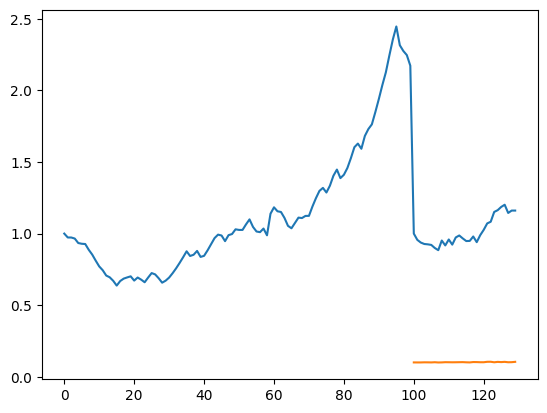

In [65]:
r=650
yy=torch.concatenate([X_test[r,:,0].cpu(),Y_test[r,:].cpu()])
xx=np.arange(days_history+days_predict)
plt.plot(xx,yy)
yyy=(model(torch.flatten(X_test[r,:,:])).detach()).cpu()  # Y_test[r,0]
plt.plot(xx[days_history:days_history+days_predict] ,yyy )


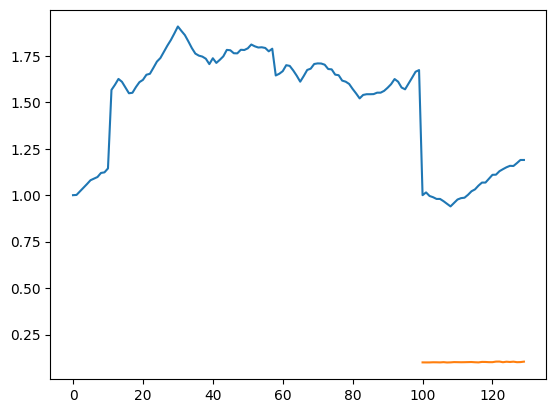

In [66]:
yy=torch.concatenate([X_train[r,:,0].cpu(),Y_train[r,:].cpu()])
xx=np.arange(days_history+days_predict)
plt.plot(xx,yy)
yyy=(model(torch.flatten(X_train[r,:,:])).detach()).cpu() # Y_test[r,0]
plt.plot(xx[days_history:days_history+days_predict] , yyy )
